HW2

The data consists of 4 runs related closed eyes, open eyes, blinking, and clenching tasks:                                                                                            
each a 2 dimensional matrix: samples (2560) * channels (16)                                                                                                                             
Channels are as follows (ordered from 1 to 16) :                                                                                                                                        
1-FPz 2-Fz 3-T7 4-T8 5-C3 6-C4 7-C5 8-C6 9-CP3 10-CP4 11-Cz 12-CPz 13-Pz 14-PO7 15-PO8 16-Oz                                                                                            
sampling rate: 256 Hz,                                                                                                                                                                  
task duration: 1 min,                                                                                                                                                                   
number of channels: 16


In [1]:
import numpy as np
from scipy.io import loadmat
import mne
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.signal import find_peaks
from scipy.signal import butter, lfilter

In [ ]:
# 1. Load the .mat file
filenames = ["S1_data.mat", "S2_data.mat", "S3_data.mat", "S4_data.mat", "S5_data.mat"]
matrices = [loadmat(filename) for filename in filenames] 
print('type(matrices):', type(matrices), 'len(matrices):', len(matrices), 'type(matrices[0]):', type(matrices[0])) 
# type(matrices): <class 'list'> len(matrices): 5 type(matrices[0]): <class 'dict'>,
#So, matrices[i] refers to ith matrix
# Print the keys in the first loaded matrix
print('matrices[0].keys():', matrices[0].keys()) # matrices[0].keys(): dict_keys(['__header__', '__version__', '__globals__', 'data'])
#so matrices[i]['data'] refers to the data of the ith matrix
print(type(matrices[0]['data']), matrices[0]['data'].shape, len(matrices[0]['data'][0, 0])) #<class 'numpy.ndarray'> (1, 1) 4
#so, matrices[i]['data'][0, 0][j] refers to the jth array of the ith matrix with shape (15360, 16): EyesOpen(j=0), EyesClosed(j=1), Blink(j=2), Clench(j=3), i=0,... ,4
 
########################################################################################################################################################################
EyesOpen=[]
EyesClosed=[]
Blink=[]
Clench=[]
for i in range( len(matrices)):
    for j in range(len(matrices[0]['data'][0, 0])):
        if j==0:
            EyesOpen.append(matrices[i]['data'][0, 0][j])
        elif j==1:
            EyesClosed.append(matrices[i]['data'][0, 0][j])
        elif j==2:
            Blink.append(matrices[i]['data'][0, 0][j])
        else:
            Clench.append(matrices[i]['data'][0, 0][j])   

print('len(EyesOpen):', len(EyesOpen), 'len(EyesClosed):', len(EyesClosed), 'len(Blink):', len(Blink), 'len(Clench):', len(Clench))   
#len(EyesOpen): 5 len(EyesClosed): 5 len(Blink): 5 len(Clench): 5
EyesOpen_np=np.array(EyesOpen)
EyesClosed_np=np.array(EyesClosed)
Blink_np=np.array(Blink)
Clench_np=np.array(Clench)
print('EyesOpen_np.shape:', EyesOpen_np.shape, 'EyesClosed_np.shape:', EyesClosed_np.shape, 'Blink_np.shape:', Blink_np.shape, 'Clench_np.shape:', Clench_np.shape) 
#EyesOpen_np.shape: (5, 15360, 16) EyesClosed_np.shape: (5, 15360, 16) Blink_np.shape: (5, 15360, 16) Clench_np.shape: (5, 15360, 16)  

######################################################################################################################################
# Read the eloc16C2.txt
with open('eloc16C2.txt', 'r') as f:
    lines = [line.strip() for line in f.readlines() if line.strip()]  # This removes any empty lines
# Check that you're only processing 16 lines
if len(lines) != 16:
    print(f"Warning: Expected 16 lines but found {len(lines)} lines.")
    for line in lines:
        print(line)  # This will print out all lines so you can inspect them
else:
    # Extract channel names, theta, and radius
    channel_names = [line.split()[3].replace('.', '') for line in lines]  
theta = np.array([float(line.split()[1])-90 for line in lines[0:]]) * np.pi / 180.0  # Convert to radians
radius = np.array([float(line.split()[2]) for line in lines[0:]])
# Convert polar to Cartesian
x = radius * np.cos(theta)/5
y = -radius * np.sin(theta)/5
z = np.zeros_like(x)  # default z-coordinate for all channels
ch_pos = dict(zip(channel_names, zip(x, y, z)))
montage = mne.channels.make_dig_montage(ch_pos, coord_frame='head')
info = mne.create_info(ch_names=channel_names, sfreq=256, ch_types='eeg')
info.set_montage(montage)
# Plot the montage
montage.plot(show_names=True)

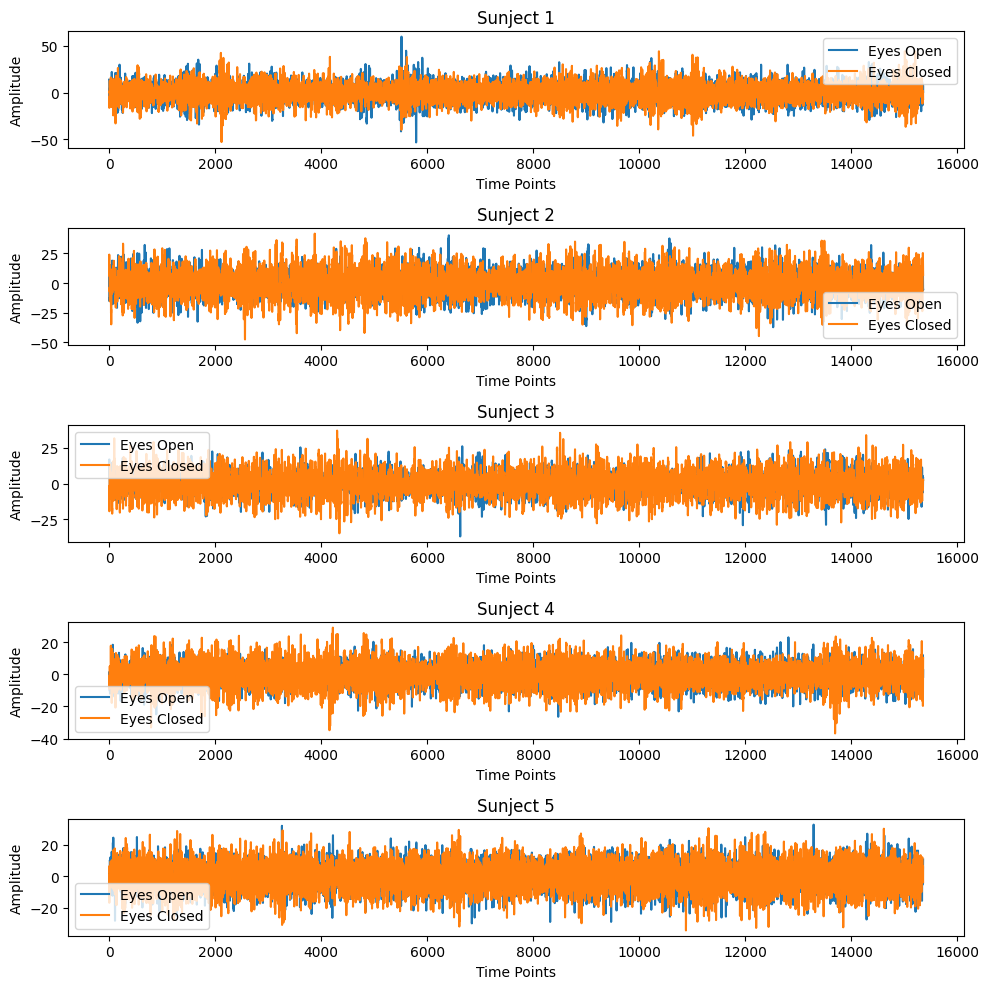

In [3]:
# Extract Oz channel data for each condition
eyes_open_oz = EyesOpen_np[:, :, 15]  # The 16th channel (0-based indexing)
eyes_closed_oz = EyesClosed_np[:, :, 15]
n_s = eyes_closed_oz.shape[0]
fig, axes = plt.subplots(n_s, 1, figsize=(10, 2*n_s))
for i in range(n_s):
    axes[i].plot(eyes_open_oz[i], label='Eyes Open')
    axes[i].plot(eyes_closed_oz[i], label='Eyes Closed')
    axes[i].set_title(f'Sunject {i + 1}')
    axes[i].set_xlabel('Time Points')
    axes[i].set_ylabel('Amplitude')
    axes[i].legend()
plt.tight_layout()
plt.show()

(a) Compute the power spectral density (PSD) of the entire eyes open and eyes closed conditions 
for channel “Oz”

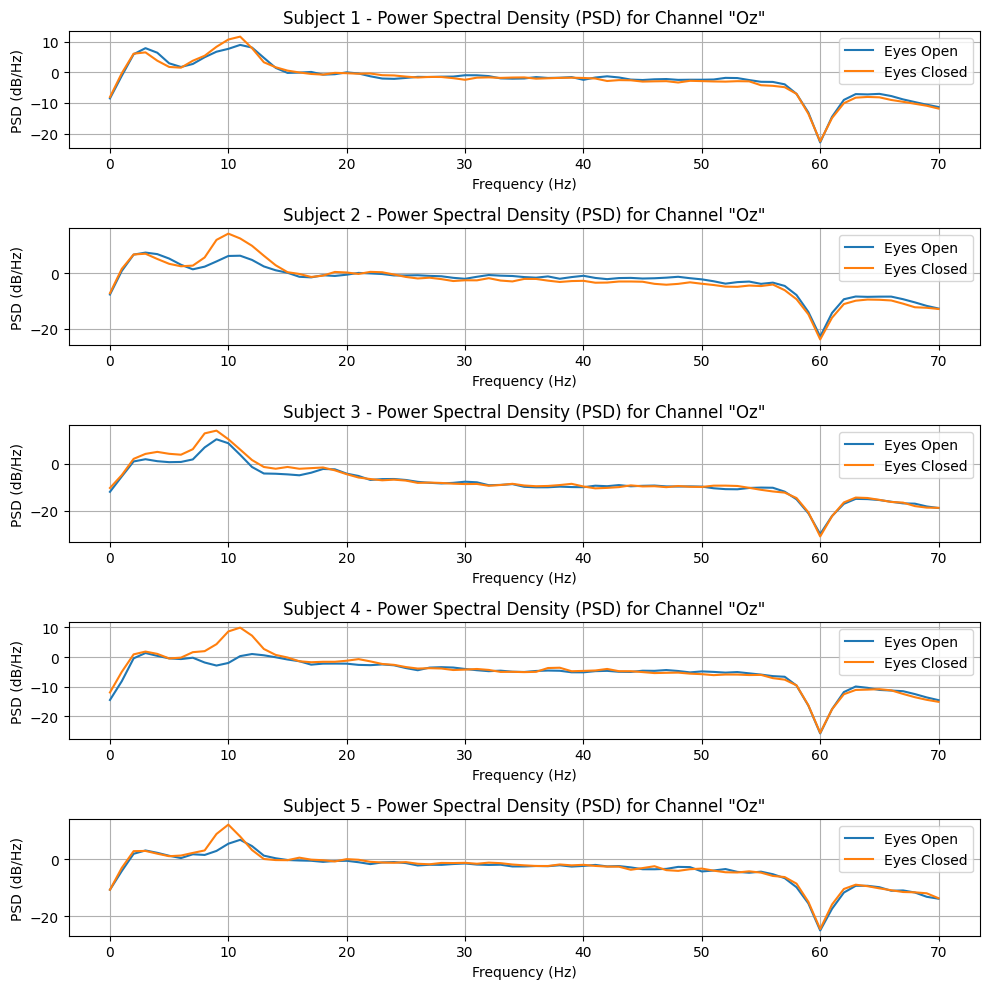

In [4]:
# a.
# Define the sampling frequency and parameters for the Welch method
fs = 256  # Given
nperseg = fs  #256 samples for a 1-second window
noverlap = nperseg // 2  # 50% overlap

# Compute PSD for each subject
frequencies, psd_open = welch(eyes_open_oz, fs=fs, nperseg=nperseg, noverlap=noverlap, axis=1)
_, psd_closed = welch(eyes_closed_oz, fs=fs, nperseg=nperseg, noverlap=noverlap, axis=1)

# Filtering the frequencies and corresponding PSD values to be within the 0-70 Hz range
mask = (frequencies >= 0) & (frequencies <= 70)
filtered_frequencies = frequencies[mask]
filtered_psd_open = psd_open[:, mask]
filtered_psd_closed = psd_closed[:, mask]
psd_open_log=10*np.log10(filtered_psd_open)
psd_closed_log=10*np.log10(filtered_psd_closed)
fig, axes = plt.subplots(n_s, 1, figsize=(10, 2*n_s))
for i in range(n_s):
    axes[i].plot(psd_open_log[i], label='Eyes Open')
    axes[i].plot(psd_closed_log[i], label='Eyes Closed')
    axes[i].set_title(f'Subject {i + 1} - Power Spectral Density (PSD) for Channel "Oz"')
    axes[i].set_xlabel('Frequency (Hz)')
    axes[i].set_ylabel('PSD (dB/Hz)')
    axes[i].legend()
    axes[i].grid(True, which='both')
plt.tight_layout()
plt.show()

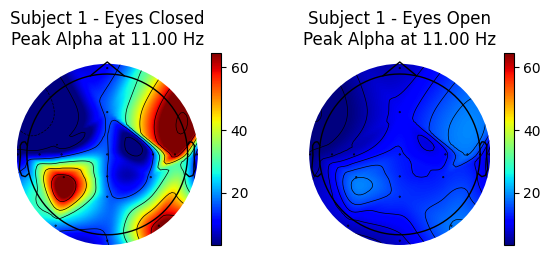

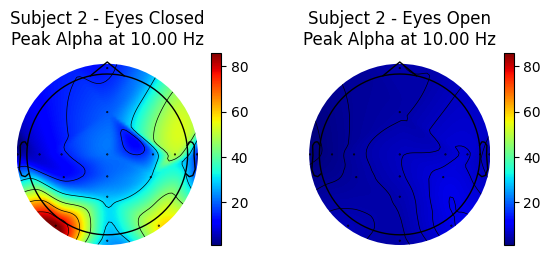

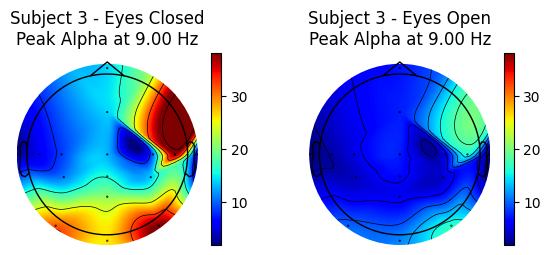

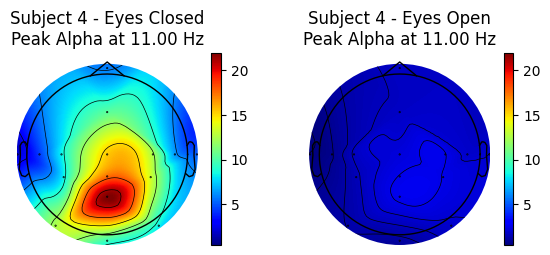

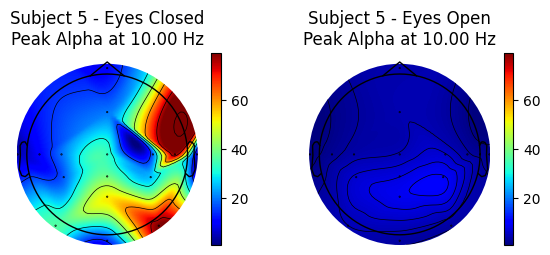

In [5]:
# b.
alpha_mask = (filtered_frequencies >= 8) & (filtered_frequencies <= 12)
alpha_psd = psd_closed_log[:, alpha_mask]
peak_alpha_indices = np.argmax(alpha_psd, axis=1)
peak_alpha_frequencies = filtered_frequencies[alpha_mask][peak_alpha_indices]
#peak_alpha_frequencies = array([11., 10.,  9., 11., 10.])
num_subjects, num_timepoints, num_channels = EyesOpen_np.shape # (5, 15360, 16)

# Preallocate arrays for storing the PSD data
psd_open_all = np.empty((num_subjects, num_channels, len(frequencies)))
psd_closed_all = np.empty((num_subjects, num_channels, len(frequencies)))

# Calculate the PSD for all channels and subjects
for channel in range(num_channels):
    _, psd_open_all[:, channel, :] = welch(EyesOpen_np[:, :, channel], fs=fs, nperseg=nperseg, noverlap=noverlap, axis=1) #shape: (5, 16, 129)
    _, psd_closed_all[:, channel, :] = welch(EyesClosed_np[:, :, channel], fs=fs, nperseg=nperseg, noverlap=noverlap, axis=1) #shape: (5, 16, 129)
    
open=[]
closed=[]

for subject in range(num_subjects):
    # Extract the peak alpha frequency for this subject
    peak_freq = peak_alpha_frequencies[subject]
    
    # Extract PSD values at the peak alpha frequency for both eyes-open and eyes-closed conditions
    closed_peak_psd_values = psd_closed_all[subject, :, frequencies == peak_freq].squeeze()
    open_peak_psd_values = psd_open_all[subject, :, frequencies == peak_freq].squeeze()
    
    closed.append(closed_peak_psd_values)
    open.append(open_peak_psd_values)
    
    # Determine consistent color limits across conditions for each sunject
    global_vmin = min(np.min(closed_peak_psd_values), np.min(open_peak_psd_values))
    global_vmax = max(np.max(closed_peak_psd_values), np.max(open_peak_psd_values))

    fig, axes = plt.subplots(1, 2, figsize=(6,2.5))
    # Eyes-closed condition
    im1, _ = mne.viz.plot_topomap(closed_peak_psd_values, info, cmap='jet', axes=axes[0], show=False)
    im1.set_clim(global_vmin, global_vmax)
    axes[0].set_title(f'Subject {subject + 1} - Eyes Closed\nPeak Alpha at {peak_freq:.2f} Hz')
    plt.colorbar(im1, ax=axes[0])
    # Eyes-open condition
    im2, _ = mne.viz.plot_topomap(open_peak_psd_values, info, cmap='jet', axes=axes[1], show=False)
    im2.set_clim(global_vmin, global_vmax)
    axes[1].set_title(f'Subject {subject + 1} - Eyes Open\nPeak Alpha at {peak_freq:.2f} Hz')
    plt.colorbar(im2, ax=axes[1])
    plt.tight_layout()
    plt.show()


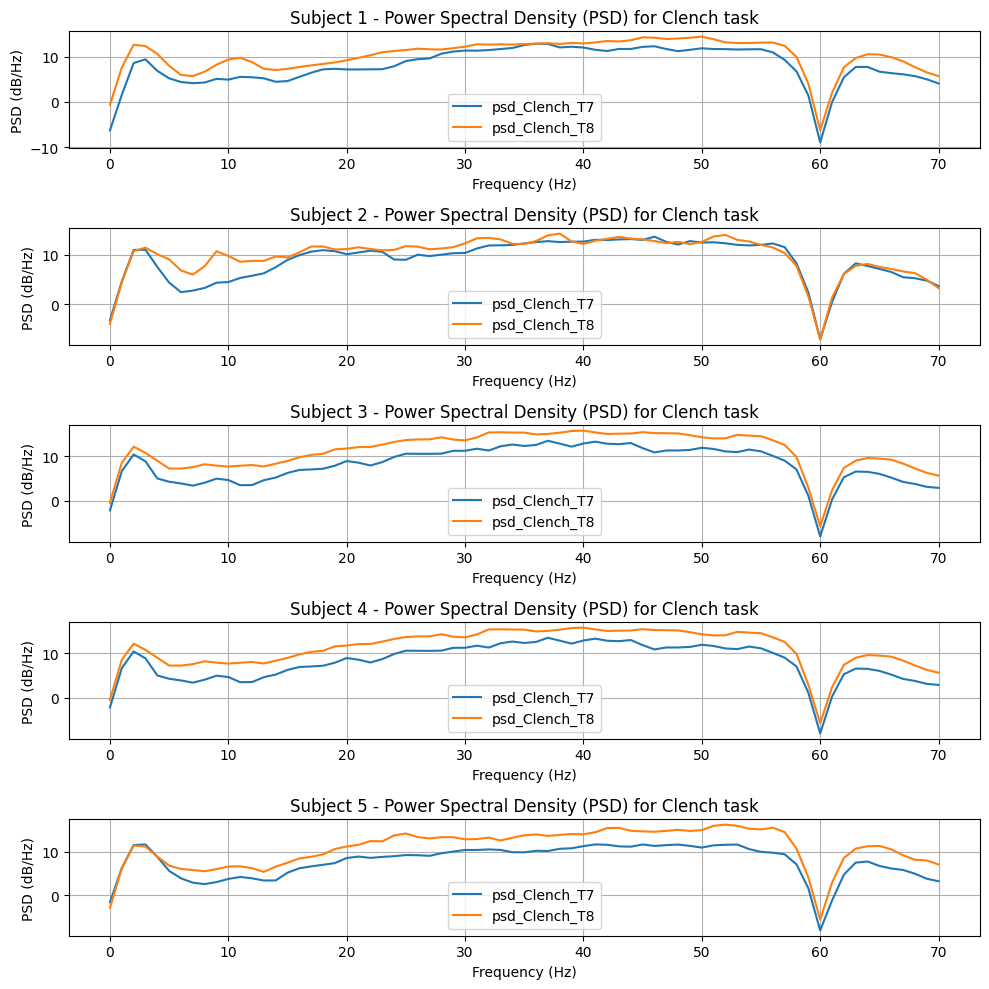

In [6]:
# c. 
# Extract channels “T7” and “T8 (2 and 3) data for each condition
Clench_np_T7 = Clench_np[:, :, 2]  
Clench_np_T8 = Clench_np[:, :, 3]
fs = 256  
nperseg = fs  #256 samples for a 1-second window
noverlap = nperseg // 2  # 50% overlap

# Compute PSD for each subject
frequencies, psd_Clench_T7 = welch(Clench_np_T7, fs=fs, nperseg=nperseg, noverlap=noverlap, axis=1)
_, psd_Clench_T8 = welch(Clench_np_T8, fs=fs, nperseg=nperseg, noverlap=noverlap, axis=1)

# Filtering the frequencies and corresponding PSD values to be within the 0-70 Hz range
mask = (frequencies >= 0) & (frequencies <= 70)
filtered_frequencies = frequencies[mask]
filtered_psd_Clench_T7 = psd_Clench_T7[:, mask]
filtered_psd_Clench_T8 = psd_Clench_T8[:, mask]
psd_Clench_T7_log=10*np.log10(filtered_psd_Clench_T7)
psd_Clench_T8_log=10*np.log10(filtered_psd_Clench_T8)
fig, axes = plt.subplots(n_s, 1, figsize=(10, 2*n_s))

for i in range(n_s):
    axes[i].plot(psd_Clench_T7_log[i], label='psd_Clench_T7')
    axes[i].plot(psd_Clench_T8_log[i], label='psd_Clench_T8')
    axes[i].set_title(f'Subject {i + 1} - Power Spectral Density (PSD) for Clench task')
    axes[i].set_xlabel('Frequency (Hz)')
    axes[i].set_ylabel('PSD (dB/Hz)')
    axes[i].legend()
    axes[i].grid(True, which='both')
plt.tight_layout()
plt.show()

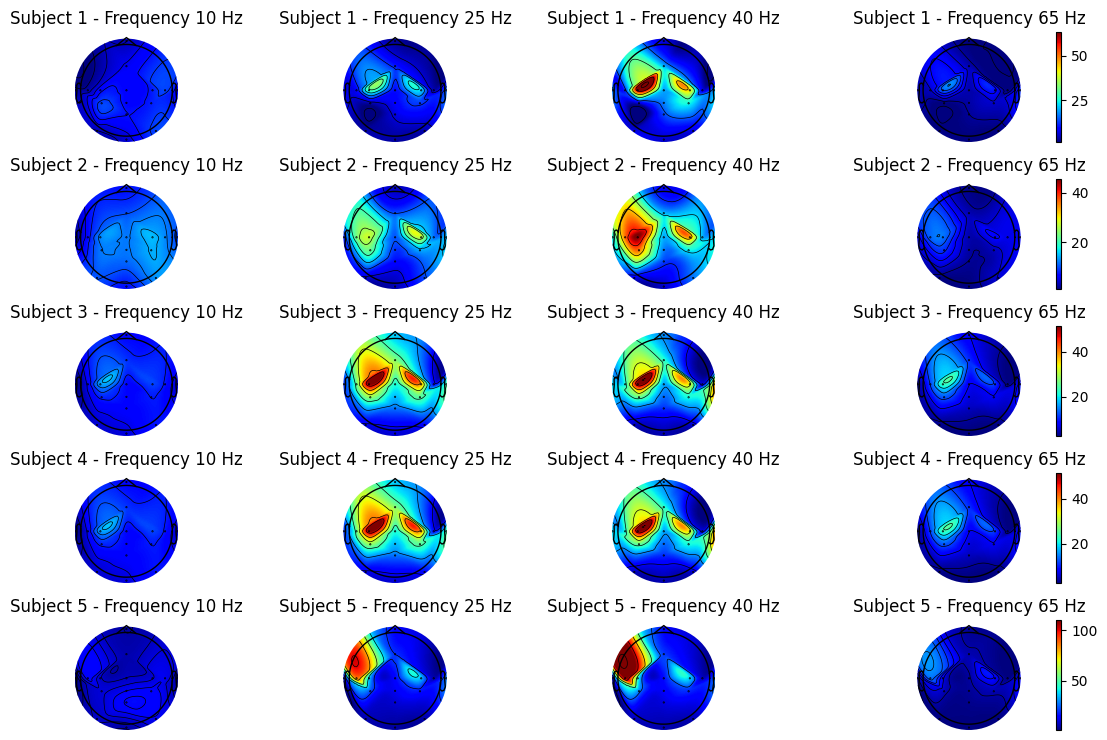

In [7]:
#d. 
# Preallocate arrays for storing the PSD data
PSD_Clench = np.empty((num_subjects, num_channels, len(frequencies)))
# psd_Clench_T8 = np.empty((num_subjects, num_channels, len(frequencies)))
clench_freq=[10, 25, 40, 65]
# Calculate the PSD for all channels and subjects
for channel in range(16):
    _, PSD_Clench[:, channel, :] = welch(Clench_np[:, :, channel], fs=fs, nperseg=nperseg, noverlap=noverlap, axis=1) #shape: (5, 16, 129)
fig, axes = plt.subplots(5, len(clench_freq), figsize=(3 * len(clench_freq), 1.5 * 5))

for subject in range(5):
    # Using a list comprehension to gather the PSD values for each frequency in clench_freq
    psd_values_for_freqs = [PSD_Clench[subject, :, frequencies == freq].squeeze() for freq in clench_freq]
    # Get global vmin and vmax for colorbar scaling for the current subject across all frequencies
    global_vmin = np.min(psd_values_for_freqs)
    global_vmax = np.max(psd_values_for_freqs)
    for idx, frequency in enumerate(clench_freq):
        clenched_psd_values = psd_values_for_freqs[idx]
        im, _ = mne.viz.plot_topomap(clenched_psd_values, info, cmap='jet', axes=axes[subject, idx], show=False)
        im.set_clim(global_vmin, global_vmax)
        axes[subject, idx].set_title(f'Subject {subject + 1} - Frequency {frequency} Hz')
    # Add individual colorbar for each subject at the rightmost column of the subplot array
    fig.colorbar(im, ax=axes[subject, -1], orientation='vertical', pad=0.1)
plt.tight_layout()
plt.show()

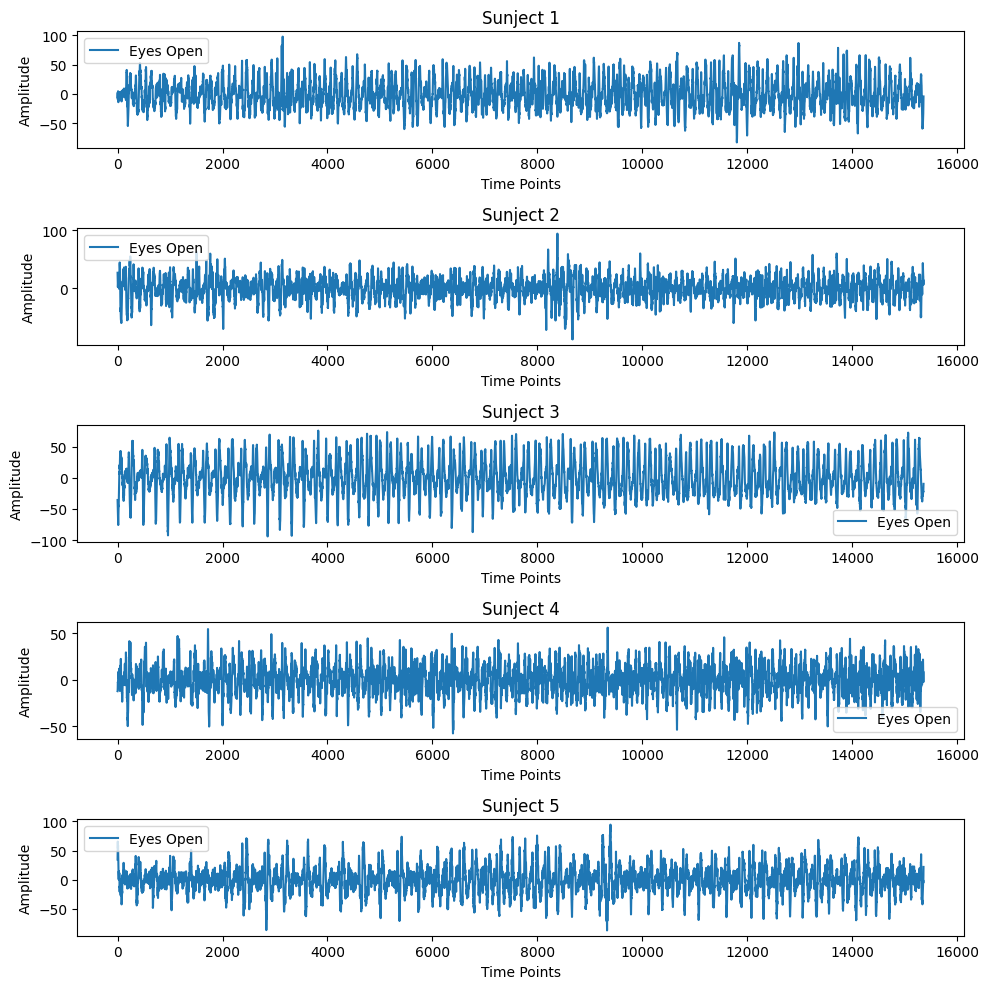

In [8]:
# 2.
# Extract Fz channel data for blinking
eyes_blink_Fz = Blink_np[:, :, 1]  # The 16th channel (0-based indexing)
n_s = eyes_blink_Fz.shape[0]
fig, axes = plt.subplots(n_s, 1, figsize=(10, 2*n_s))
for i in range(n_s):
    axes[i].plot(eyes_blink_Fz[i], label='Eyes Open')
    axes[i].set_title(f'Sunject {i + 1}')
    axes[i].set_xlabel('Time Points')
    axes[i].set_ylabel('Amplitude')
    axes[i].legend()
plt.tight_layout()
plt.show()

peak_blink_frequencies: [3. 2. 3. 3. 2.]


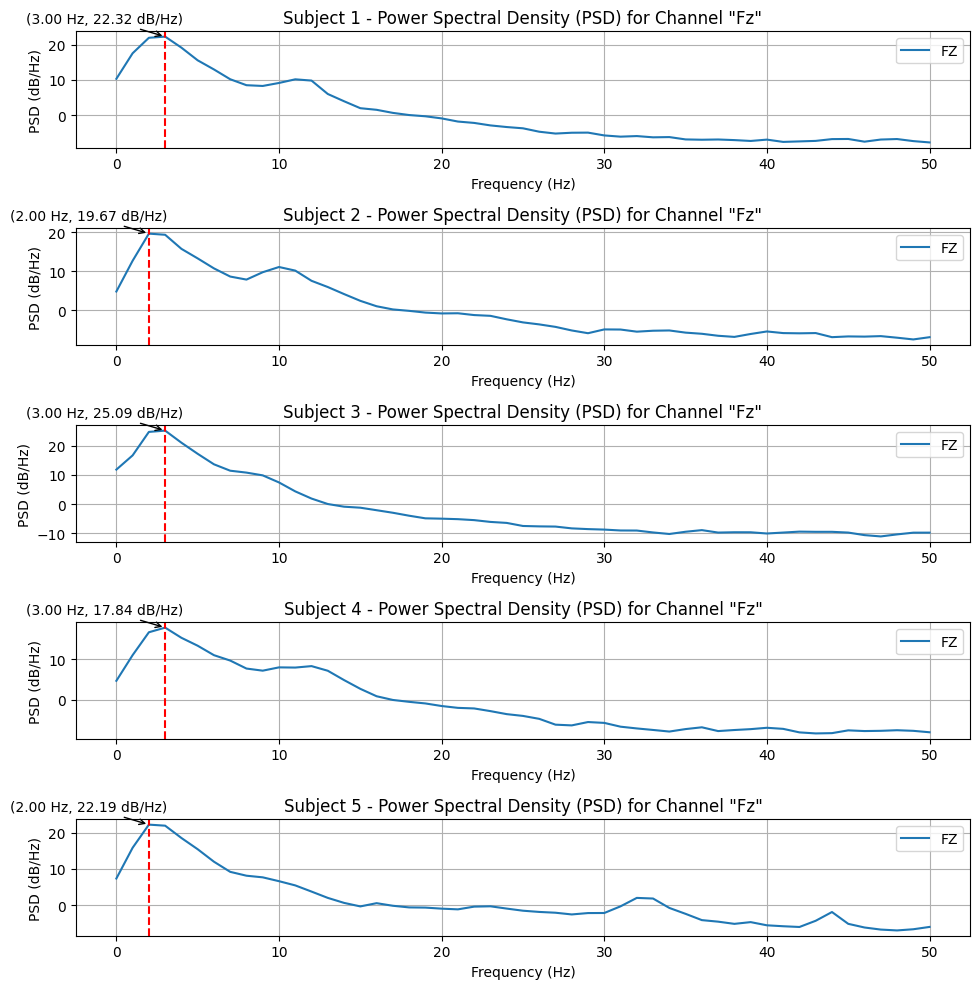

In [9]:
# 2.
# Define the sampling frequency and parameters for the Welch method
fs = 256  # Given
nperseg = fs  #256 samples for a 1-second window
noverlap = nperseg // 2  # 50% overlap

# Compute PSD for each subject
frequencies, psd_blink_Fz = welch(eyes_blink_Fz, fs=fs, nperseg=nperseg, noverlap=noverlap, axis=1)

# Filtering the frequencies and corresponding PSD values to be within the 0-50 Hz range,
mask = (frequencies >= 0) & (frequencies <= 50)
filtered_frequencies = frequencies[mask]
filtered_psd_blink_FZ = psd_blink_Fz[:, mask]
psd_blink_log_FZ=10*np.log10(filtered_psd_blink_FZ)

# calculate the peak frequency
blink_mask = (filtered_frequencies >= 1) & (filtered_frequencies <= 15)
blink_psd = psd_blink_log_FZ[:, blink_mask]
peak_blink_indices = np.argmax(blink_psd, axis=1)
peak_blink_frequencies = filtered_frequencies[blink_mask][peak_blink_indices]
print('peak_blink_frequencies:', peak_blink_frequencies)
# peak_blink_frequencies: [3. 2. 3. 3. 2.]

# Now modify your plotting loop:
fig, axes = plt.subplots(n_s, 1, figsize=(10, 2*n_s))
for i in range(n_s):
    axes[i].plot(filtered_frequencies, psd_blink_log_FZ[i], label='FZ')
    
    # Add a red dotted line for the peak frequency
    peak_freq = peak_blink_frequencies[i]
    peak_power = psd_blink_log_FZ[i][filtered_frequencies == peak_freq]
    axes[i].axvline(x=peak_freq, color='red', linestyle='--')
    
    # Annotate the point with frequency and power value
    annotation_text = f'({peak_freq:.2f} Hz, {peak_power[0]:.2f} dB/Hz)'
    axes[i].annotate(annotation_text, xy=(peak_freq, peak_power[0]), xycoords='data',
                     xytext=(-100, 10), textcoords='offset points', 
                     arrowprops=dict(arrowstyle="->"))
    
    axes[i].set_title(f'Subject {i + 1} - Power Spectral Density (PSD) for Channel "Fz"')
    axes[i].set_xlabel('Frequency (Hz)')
    axes[i].set_ylabel('PSD (dB/Hz)')
    axes[i].legend()
    axes[i].grid(True, which='both')

plt.tight_layout()
plt.show()



The eye blink detector was developed using a sliding window approach on EEG data. Each window was of length 256 samples (equivalent to 1 second) with an overlap of 30%, ensuring a robust and dense coverage of the entire data sequence. Within each window, the data was bandpassed (.5-30 Hz) to get rid of the noises that might be considered as eye blinks, and also squared to improve its resilience against minor fluctuations and to accentuate the amplitude of potential blinks. A dynamic threshold for peak detection was then computed for each windowed segment based on the formula: (mean of the squared data plus 2.5 times its standard deviation). Peaks, indicative of eye blinks, were subsequently identified within these windowed segments by determining points where the amplitude exceeded the computed threshold. To maintain accuracy and avoid counting the same blink from adjacent overlapping windows, a minimum distance :(length 128 samples (equivalent to 0.5 second)) constraint was enforced between successive peaks. After processing the entire dataset, the detected peaks from all the windows were collated, and any duplicates arising from the overlap mechanism were prudently removed. This procedure was iteratively executed for each subject's data, resulting in a list of detected blink instances. By harnessing a blend of amplitude thresholding, peak detection, and the sliding window technique with its inherent overlap, the method offers a meticulous and precise identification of eye blinks.

In [16]:
def compute_threshold(eeg_data, k=2.5):
    """
    Computes the amplitude threshold for blink detection.

    Parameters:
    - eeg_data: 1D array representing EEG data.
    - k: constant multiplier for the standard deviation.

    Returns:
    - Threshold for blink detection.
    """
    return np.mean(eeg_data) + k * np.std(eeg_data), #std: Compute the standard deviation 


def detect_blinks(eeg_data, threshold):
    """
    Detects eye blinks based on amplitude thresholding.

    Parameters:
    - eeg_data: 1D array representing EEG data.
    - threshold: amplitude threshold for detecting blinks.

    Returns:
    - blink_times: indices where blinks are detected.
    """
    blink_times = np.where(np.abs(eeg_data) > threshold)[0]
    return blink_times

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Apply filter
lowcut = 0.5
highcut = 30.0
filtered_eyes_blink_Fz = butter_bandpass_filter(eyes_blink_Fz, lowcut, highcut, fs)


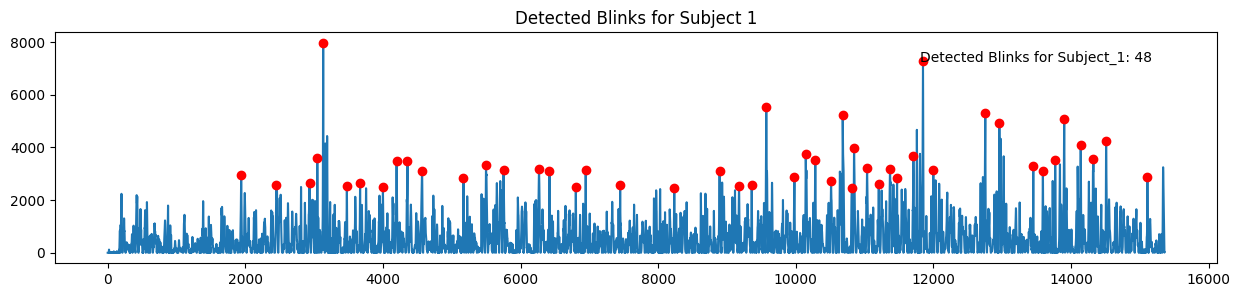

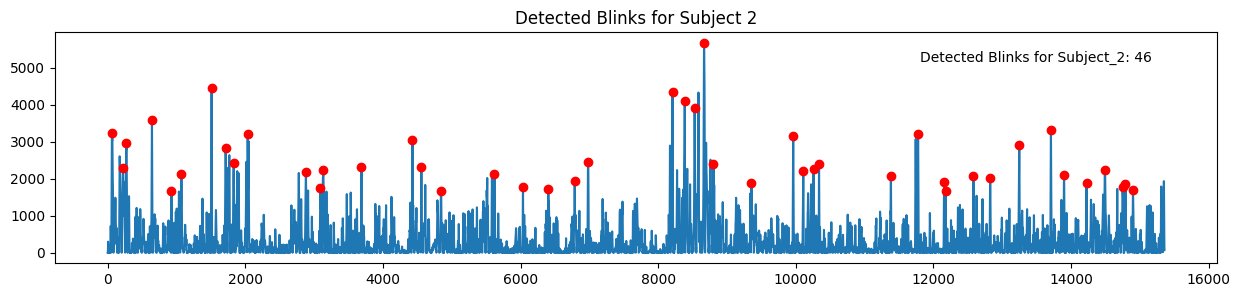

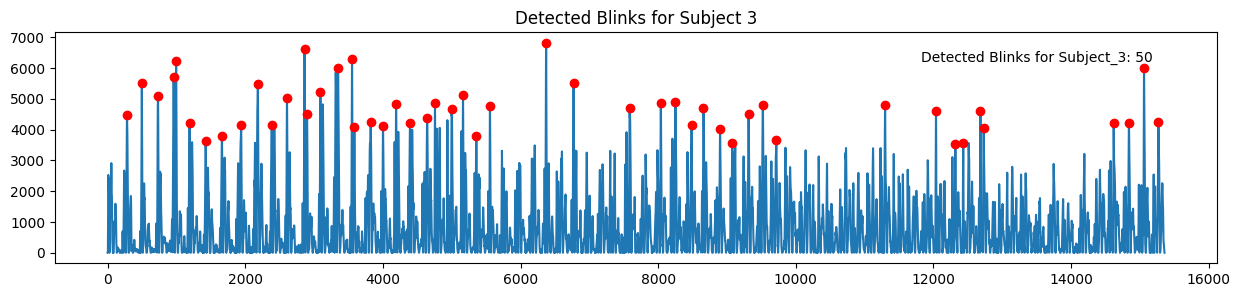

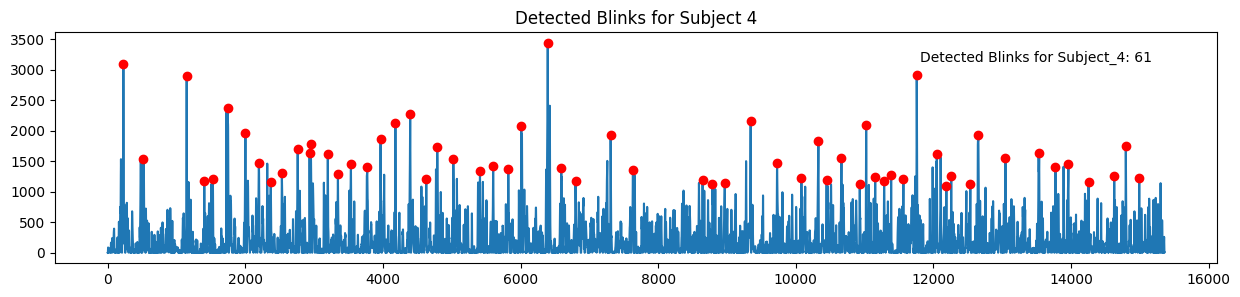

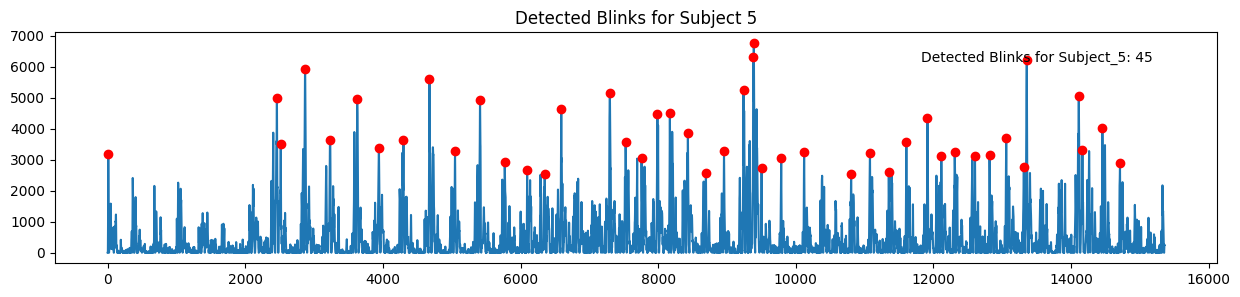

[list([1940, 2450, 2933, 3046, 3132, 3476, 3668, 4000, 4198, 4357, 4569, 5171, 5498, 5753, 6268, 6420, 6803, 6947, 7448, 8234, 8893, 9175, 9360, 9571, 9980, 10145, 10283, 10513, 10682, 10814, 10847, 11036, 11206, 11370, 11472, 11709, 11849, 11999, 12754, 12959, 13452, 13591, 13770, 13901, 14141, 14325, 14511, 15110])
 list([67, 224, 273, 643, 926, 1071, 1510, 1713, 1831, 2034, 2880, 3091, 3134, 3688, 4429, 4559, 4846, 5621, 6035, 6404, 6787, 6983, 8209, 8386, 8530, 8667, 8804, 9355, 9963, 10109, 10258, 10338, 11382, 11778, 12155, 12177, 12582, 12825, 13248, 13708, 13899, 14226, 14492, 14749, 14791, 14900])
 list([280, 496, 731, 959, 995, 1190, 1423, 1660, 1940, 2182, 2384, 2605, 2861, 2897, 3091, 3348, 3551, 3585, 3822, 4001, 4191, 4393, 4643, 4757, 4998, 5164, 5359, 5555, 6372, 6771, 7585, 8039, 8251, 8485, 8658, 8900, 9078, 9314, 9522, 9717, 11298, 12038, 12320, 12434, 12684, 12731, 14620, 14842, 15061, 15270])
 list([228, 511, 1148, 1404, 1529, 1744, 2002, 2196, 2370, 2531, 2761, 29

C:\Users\tnlab\AppData\Local\Temp\ipykernel_25940\1857849039.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  blink_times_array = np.array(blink_times_all_subjects)


In [17]:
distance_between_peaks = 128  # Half of one second between peaks; adjust as needed
window_size = 256 # 1 seconds window size
window_step = int(window_size * 0.7)  # 30% overlap
blink_times_all_subjects = []  # Master list to store blink times for all subjects

# Process each epoch of the data
for subject_num, epoch_data in enumerate(filtered_eyes_blink_Fz, start=1):
    squared_data = epoch_data**2  # Square the data for more resilience
    threshold = compute_threshold(squared_data)  # Compute threshold for the squared data
    all_peaks = []

    # Slide the window through the data
    for start in range(0, len(squared_data) - window_size + 1, window_step):
        end = start + window_size
        windowed_data = squared_data[start:end]
        # Detect peaks in the windowed data
        peaks, _ = find_peaks(windowed_data, height=threshold, distance=distance_between_peaks)
        peaks = peaks + start  # Adjust peak indices for the entire data
        all_peaks.extend(peaks)
    
    # Remove duplicate peaks
    all_peaks = list(set(all_peaks))
    all_peaks.sort()
    
    # Append the blink times for this epoch to the master list
    blink_times_all_subjects.append(all_peaks)

    # Print the number of detected blinks
    # print(f"Detected {len(all_peaks)} blinks in this epoch.")

    # Visualize detected blinks
    plt.figure(figsize=(15, 3))
    plt.plot(squared_data)
    plt.plot(all_peaks, squared_data[all_peaks], "ro")
    
    # Set title to indicate the subject number
    plt.title(f"Detected Blinks for Subject {subject_num}")
    
    # Annotate the number of peaks detected
    plt.annotate(f"Detected Blinks for Subject_{subject_num}: {len(all_peaks)}", 
                 xy=(0.95, 0.95), xycoords='axes fraction', 
                 fontsize=10, 
                 xytext=(-5, -5), textcoords='offset points',
                 ha='right', va='top')
    plt.show()
# Convert the master list to an array for convenience
blink_times_array = np.array(blink_times_all_subjects)
print(blink_times_array)

To validate the performance of the developed blink detector, we randomly selected five instances from the detected blinks. Topographic maps for these instances are presented. In most of these topographic representations, we observed heightened activity in the frontal area. This prominent frontal activity serves as evidence supporting the accuracy and effectiveness of our developed detector.

Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_chan

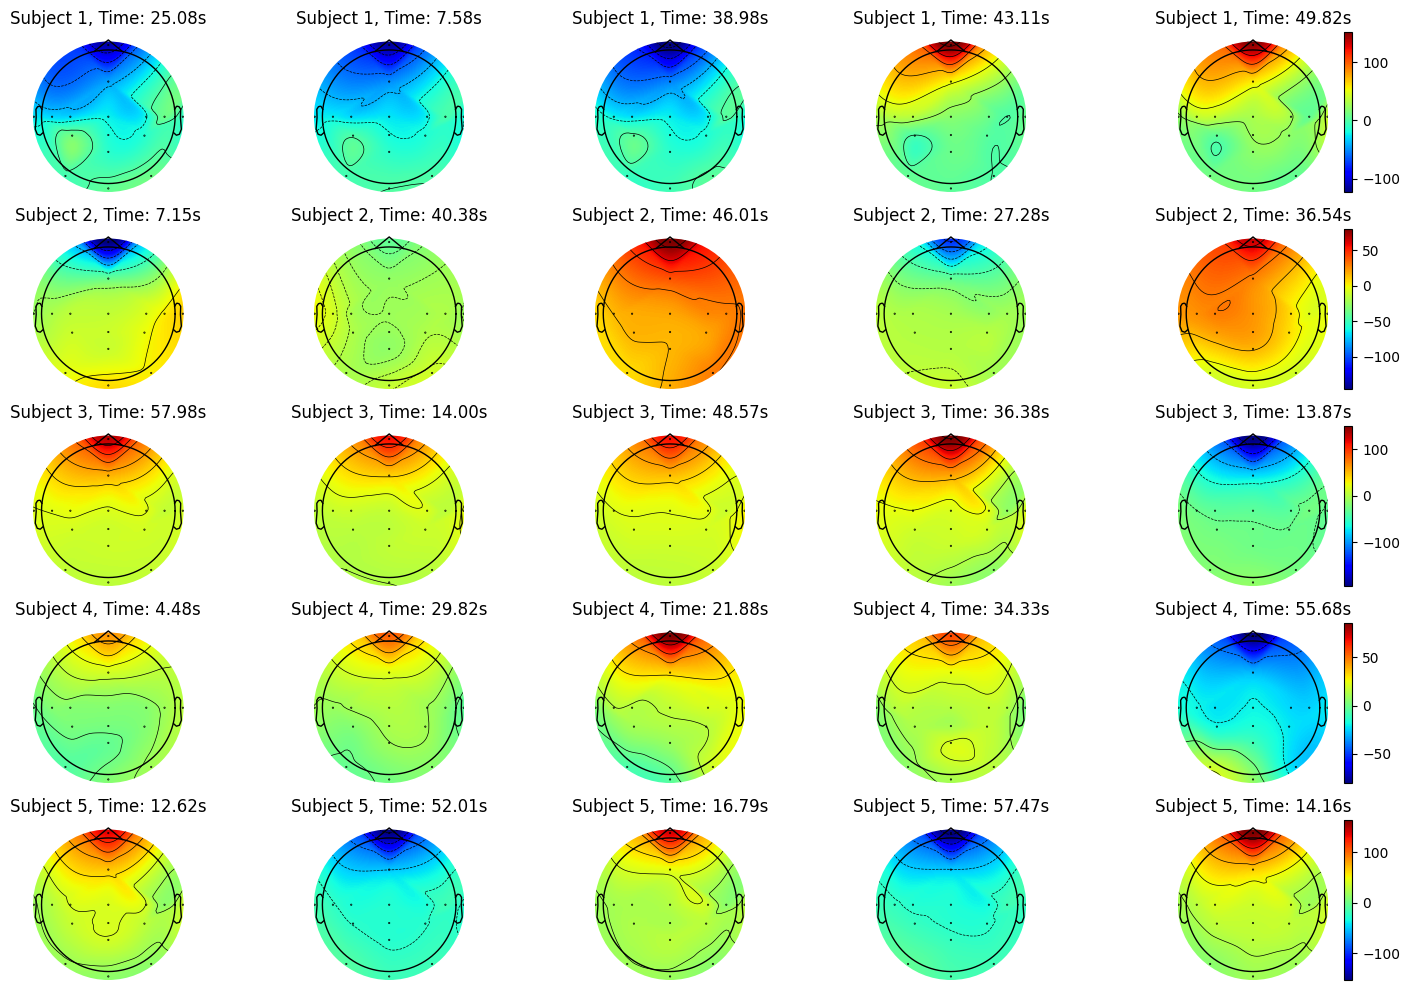

In [19]:
# Validation
# Reshape the data to (n_epochs, n_channels, n_times)
Blink = np.transpose(Blink_np, (0, 2, 1))

# Create an EpochsArray object using your provided info
events = np.array([[i, 0, 1] for i in range(Blink.shape[0])])
epochs = mne.EpochsArray(Blink, info, events=events)

# Precompute the global minimum and maximum across subjects and blink times for consistent colormap scaling
global_vmin = np.inf
global_vmax = -np.inf

for i in range(Blink.shape[0]):
    random_blink_times = np.random.choice(blink_times_array[i], 5, replace=False)
    for blink_time in random_blink_times:
        time_point = blink_time / epochs.info['sfreq']
        data = epochs[i].average().data[:, epochs.time_as_index([time_point])[0]]
        global_vmin = min(global_vmin, data.min())
        global_vmax = max(global_vmax, data.max())
fig, axs = plt.subplots(Blink.shape[0], 5, figsize=(15, 10))

for i in range(Blink.shape[0]):
    # Randomly select 5 blink times for this subject
    random_blink_times = np.random.choice(blink_times_array[i], 5, replace=False)
    # Convert sample points to time in seconds
    random_time_points = random_blink_times / epochs.info['sfreq']
    # Get data values for the randomly selected times and determine their min and max
    subject_data = epochs[i].average().data # This Evoked object contains the grand average (averaged over trials or epochs) of the data for each channel.
    subject_values_at_times = [subject_data[:, int(tp * epochs.info['sfreq'])] for tp in random_time_points]
    subject_vmin = min([np.min(val) for val in subject_values_at_times])
    subject_vmax = max([np.max(val) for val in subject_values_at_times])
    
    # For each of these blink times
    for j, time_point in enumerate(random_time_points):
        # Plot the topomap for this time point 
        data_at_time = subject_data[:, int(time_point * epochs.info['sfreq'])]
        im1, _ = mne.viz.plot_topomap(data_at_time, epochs.info, cmap='jet', axes=axs[i, j], show=False)
        im1.set_clim(subject_vmin, subject_vmax)
        axs[i, j].set_title(f"Subject {i+1}, Time: {time_point:.2f}s")
    fig.colorbar(im1, ax=axs[i, 4], orientation='vertical', pad=0.05)    
plt.tight_layout()
plt.show()